In [152]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

## Create Data

In [153]:
def hamiltonian_fn(coords):
    q, p = np.split(coords,2)
    H = 3*(1-np.cos(q)) + p**2 # pendulum hamiltonian
    return H

def dynamics_fn(t, coords):
    dcoords = autograd.grad(hamiltonian_fn)(coords)
    dqdt, dpdt = np.split(dcoords,2)
    S = np.concatenate([dpdt, -dqdt], axis=-1)
    return S

def get_trajectory(t_span=[0,3], timescale=15, radius=None, y0=None, noise_std=0.1, **kwargs):
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))
    
    # get initial state
    if y0 is None:
        y0 = np.random.rand(2)*2.-1
    if radius is None:
        radius = np.random.rand() + 1.3 # sample a range of radii
    y0 = y0 / np.sqrt((y0**2).sum()) * radius ## set the appropriate radius

    spring_ivp = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10, **kwargs)
    q, p = spring_ivp['y'][0], spring_ivp['y'][1]
    dydt = [dynamics_fn(None, y) for y in spring_ivp['y'].T]
    dydt = np.stack(dydt).T
    dqdt, dpdt = np.split(dydt,2)
    
    # add noise
    q += np.random.randn(*q.shape)*noise_std
    p += np.random.randn(*p.shape)*noise_std
    return q, p, dqdt, dpdt, t_eval

def get_dataset(seed=0, samples=50, test_split=0.5, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        x, y, dx, dy, t = get_trajectory(**kwargs)
        xs.append( np.stack( [x, y]).T )
        dxs.append( np.stack( [dx, dy]).T )
        
    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

def get_field(xmin=-1.2, xmax=1.2, ymin=-1.2, ymax=1.2, gridsize=20):
    field = {'meta': locals()}

    # meshgrid to get vector field
    b, a = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
    ys = np.stack([b.flatten(), a.flatten()])
    
    # get vector directions
    dydt = [dynamics_fn(None, y) for y in ys.T]
    dydt = np.stack(dydt).T

    field['x'] = ys.T
    field['dx'] = dydt.T
    return field

In [154]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'pend',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Plot Data

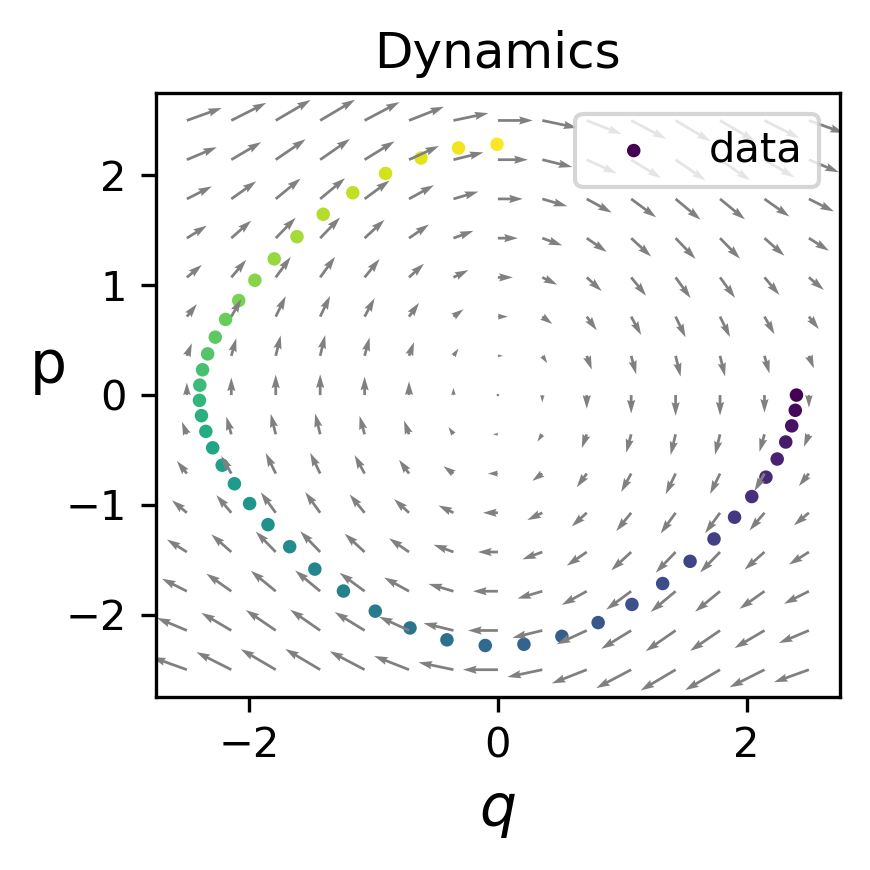

In [155]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
R = 2.5
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=15)
data = get_dataset()

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(t_span=[0,3], radius=2.4, y0=np.array([2,0]), noise_std=0)
plt.scatter(x,y,c=t,s=5, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("p", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()

## Lern Network

In [156]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.fc1 = nn.Linear(2, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 2)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [157]:
qp = torch.tensor( data['x'], requires_grad=True, dtype=torch.float32)
dqp = torch.Tensor(data['dx'])

qp_test = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32)
dqp_test = torch.Tensor(data['test_dx'])

In [158]:
q_p = torch.stack([torch.tensor(x, requires_grad=True), torch.tensor(y, requires_grad=True)], dim=1)
dq_dp = torch.stack([torch.tensor(dx[0], requires_grad=True), torch.tensor(dy[0], requires_grad=True)], dim=1) 

In [159]:
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()

def train(model, optimizer, loss, x, dx, x_test, dx_test, epochs):
    for step in range(epochs):
        model.train()
        optimizer.zero_grad()
        x_pred = model(x)
        loss_val = loss(x_pred, dx)
        loss_val.backward()
        optimizer.step()

        # test loss
        model.eval()
        with torch.no_grad():
            x_pred_test = model(x_test)
            loss_val_test = loss(x_pred_test, dx_test)
        
        print(f"Epoch {step+1}/{epochs} --- Train-Loss: {round(loss_val.item(), 3)}; Test-Loss: {round(loss_val_test.item(), 3)}")

train(model, optimizer, loss, qp, dqp, qp_test, dqp_test, 30)

Epoch 1/30 --- Train-Loss: 5.824; Test-Loss: 4.115
Epoch 2/30 --- Train-Loss: 4.265; Test-Loss: 2.871
Epoch 3/30 --- Train-Loss: 2.982; Test-Loss: 1.906
Epoch 4/30 --- Train-Loss: 1.974; Test-Loss: 1.207
Epoch 5/30 --- Train-Loss: 1.226; Test-Loss: 0.748
Epoch 6/30 --- Train-Loss: 0.718; Test-Loss: 0.492
Epoch 7/30 --- Train-Loss: 0.415; Test-Loss: 0.397
Epoch 8/30 --- Train-Loss: 0.279; Test-Loss: 0.419
Epoch 9/30 --- Train-Loss: 0.266; Test-Loss: 0.511
Epoch 10/30 --- Train-Loss: 0.332; Test-Loss: 0.631
Epoch 11/30 --- Train-Loss: 0.435; Test-Loss: 0.746
Epoch 12/30 --- Train-Loss: 0.538; Test-Loss: 0.832
Epoch 13/30 --- Train-Loss: 0.619; Test-Loss: 0.879
Epoch 14/30 --- Train-Loss: 0.666; Test-Loss: 0.887
Epoch 15/30 --- Train-Loss: 0.677; Test-Loss: 0.86
Epoch 16/30 --- Train-Loss: 0.655; Test-Loss: 0.805
Epoch 17/30 --- Train-Loss: 0.608; Test-Loss: 0.732
Epoch 18/30 --- Train-Loss: 0.545; Test-Loss: 0.65
Epoch 19/30 --- Train-Loss: 0.473; Test-Loss: 0.567
Epoch 20/30 --- Train-L

In [160]:
model_HNN = MLP()
optimizer = torch.optim.Adam(model_HNN.parameters(), lr=1e-3)
loss = nn.MSELoss()

def train(model, optimizer, loss, x, dx, x_test, dx_test, epochs):
    
    for step in range(epochs):
        model.train()
        optimizer.zero_grad()
        x_pred = model(x)

        x_field = torch.autograd.grad(x_pred.sum(), x, create_graph=True)[0] # gradients for conservative field
        dH = torch.zeros_like(x_field)
        dH.T[0] = x_field.T[1]
        dH.T[1] = -x_field.T[0]

        loss_val = loss(dH, dx)
        loss_val.backward()
        optimizer.step()

        # test loss
        model.eval()
        x_pred_test = model(x_test)
        x_field = torch.autograd.grad(x_pred_test.sum(), x_test, create_graph=True)[0] # gradients for conservative field
        dH = torch.zeros_like(x_field)
        dH.T[0] = x_field.T[1]
        dH.T[1] = -x_field.T[0]

        loss_val_test = loss(dH, dx_test)
        
        print(f"Epoch {step+1}/{epochs} --- Train-Loss: {round(loss_val.item(), 3)}; Test-Loss: {round(loss_val_test.item(), 3)}")

train(model_HNN, optimizer, loss, qp, dqp, qp_test, dqp_test, 30)

Epoch 1/30 --- Train-Loss: 6.414; Test-Loss: 5.734
Epoch 2/30 --- Train-Loss: 5.887; Test-Loss: 5.264
Epoch 3/30 --- Train-Loss: 5.392; Test-Loss: 4.822
Epoch 4/30 --- Train-Loss: 4.926; Test-Loss: 4.405
Epoch 5/30 --- Train-Loss: 4.487; Test-Loss: 4.012
Epoch 6/30 --- Train-Loss: 4.075; Test-Loss: 3.643
Epoch 7/30 --- Train-Loss: 3.688; Test-Loss: 3.295
Epoch 8/30 --- Train-Loss: 3.324; Test-Loss: 2.969
Epoch 9/30 --- Train-Loss: 2.984; Test-Loss: 2.663
Epoch 10/30 --- Train-Loss: 2.665; Test-Loss: 2.377
Epoch 11/30 --- Train-Loss: 2.367; Test-Loss: 2.109
Epoch 12/30 --- Train-Loss: 2.088; Test-Loss: 1.86
Epoch 13/30 --- Train-Loss: 1.828; Test-Loss: 1.628
Epoch 14/30 --- Train-Loss: 1.587; Test-Loss: 1.415
Epoch 15/30 --- Train-Loss: 1.364; Test-Loss: 1.222
Epoch 16/30 --- Train-Loss: 1.161; Test-Loss: 1.049
Epoch 17/30 --- Train-Loss: 0.979; Test-Loss: 0.897
Epoch 18/30 --- Train-Loss: 0.82; Test-Loss: 0.769
Epoch 19/30 --- Train-Loss: 0.685; Test-Loss: 0.666
Epoch 20/30 --- Train-L

## visualize Results

In [161]:
def calc_traj(model, q0_p0, t):
    q_p_pred = []

    q_p_pred.append(q0_p0.double())
    for i in t:
        pred = model(q_p_pred[-1])
        q_p_pred.append(q_p_pred[-1]+pred*(t[1]-t[0]))

    q_p_pred = torch.stack(q_p_pred).detach().numpy()
    return q_p_pred

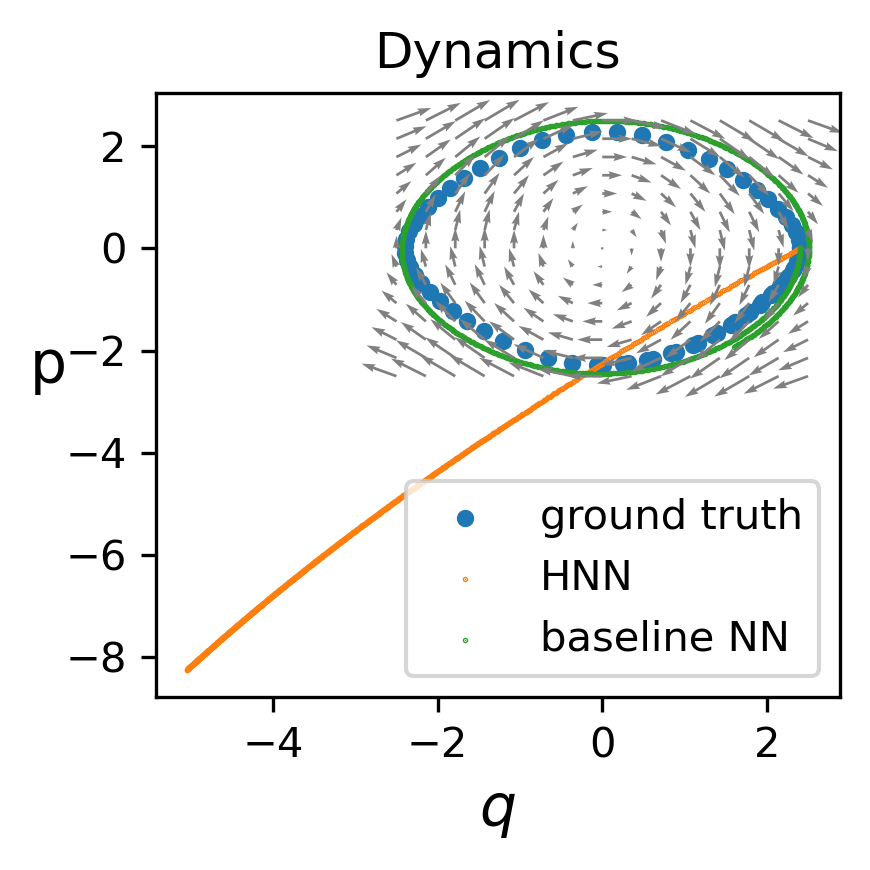

In [162]:
# plot config
q0_p0 = torch.tensor([2.4,0])
t = torch.linspace(0, 5, 1000)

qp_HNN = calc_traj(model_HNN.double(), q0_p0, t)
qp_NN = calc_traj(model.double(), q0_p0, t)
x, y, dx, dy, t = get_trajectory(t_span=[torch.min(t), torch.max(t)], radius=2.4, y0=np.array([2,0]), noise_std=0)

fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

plt.scatter(x,y,s=10, label='ground truth')
plt.scatter(qp_HNN.T[0],qp_HNN.T[1],s=0.1, label='HNN')
plt.scatter(qp_NN.T[0],qp_NN.T[1],s=0.1, label='baseline NN')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("p", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend()

plt.tight_layout() ; plt.show()